Course: https://www.udemy.com/course/time-series-analysis/

# Section 4: Exponential Smoothing and ETS Methods

- EST stands for "Error-Trend-Seasonality", used as synonym for Exponential Smoothing models
- The data for this course is available at: https://docs.google.com/document/d/1SiG1V325FQ4bqhUFEoXGhkAK89RSS0tplcJBCuivn_s/edit?usp=sharing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# SMA Code
- Exploring Simple Moving Average 

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/sp500_close.csv

File ‘sp500_close.csv’ already there; not retrieving.



In [3]:
close = pd.read_csv('sp500_close.csv',index_col=0,parse_dates=True)
close.head()

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
2013-02-08,14.75,67.8542,78.90,36.25,46.89,34.41,73.31,39.12,45.70,30.22,...,37.51,28.24,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-11,14.46,68.5614,78.39,35.85,46.76,34.26,73.07,38.64,46.08,30.28,...,37.46,28.31,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,14.27,66.8428,78.60,35.42,46.96,34.30,73.37,38.89,46.27,30.81,...,37.58,28.41,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74


- Get Google closing prices

In [4]:
goog = close[['GOOG']].copy().dropna()
goog.head()

,GOOG
2014-03-27,558.46
2014-03-28,559.99
2014-03-31,556.97
2014-04-01,567.16
2014-04-02,567.00


Text(0, 0.5, 'Closing Stock Prices')

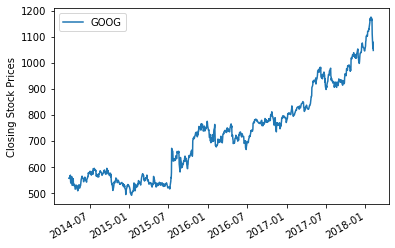

In [5]:
goog.plot()
plt.ylabel('Closing Stock Prices')

- Calculate log returns: $r_t = \log(1+R_t)=\log\left(1+\frac{P_t-P_{t-1}}{P_t}\right)$
- But the latter term in the sum is just the percent change of the price so:

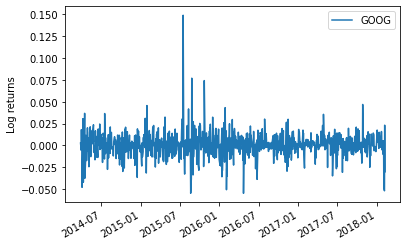

In [6]:
goog_ret = np.log(1+goog.pct_change(1))
goog_ret.plot()

# plot it
plt.ylabel('Log returns')
plt.show()

- Add SMA to google price df for two window sizes: 10 and 50
- Note that rolling() returns a pd Rolling object

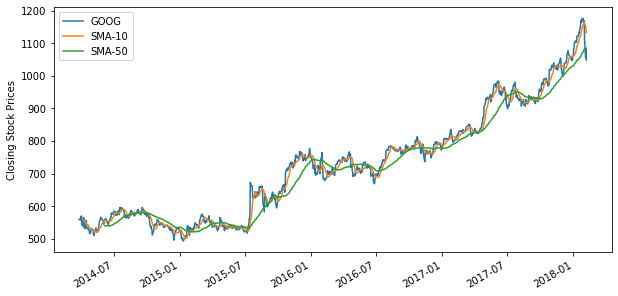

In [7]:
goog['SMA-10'] = goog['GOOG'].rolling(10).mean()
goog['SMA-50'] = goog['GOOG'].rolling(50).mean()

# Plot them
plt.figure(figsize=(10,5))
goog['GOOG'].plot()
goog['SMA-10'].plot()
goog['SMA-50'].plot()
plt.ylabel('Closing Stock Prices')
plt.legend()
plt.show()

- Note how the larger the window size, the more the SMA "lags" behind (most noticeable in the peaks)
    - This makes sense as all points in the window are equally weighted, so larger window size carries an average that is mostly representative of long term trends
    - Shorter term trends (e.g spikes) can either be washed out if they're short enough or will only be reflected in the SMA once/if many such points have been taken into account
- The next exercise for this section is to repeat the same thing but with Google and Apple prices at once. Since it's the same exercise but using a df with two columns instead of one, I omit it as uninstructive

# EWMA Code
- Explore exponentially weights moving average
- Apply exponentially moving average to number of monthly passengers data

In [8]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File ‘airline_passengers.csv’ already there; not retrieving.



In [9]:
df = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


- Use pandas ewm to perform EWMA:

In [10]:
alpha = 0.2 # randomly picked by instructor. Since alpha is low, resulting curve should be smooth

df['EWMA'] = df['Passengers'].ewm(alpha=alpha,adjust=False).mean() # adjust = False to use EWMA as described in lecture

<Figure size 720x360 with 0 Axes>

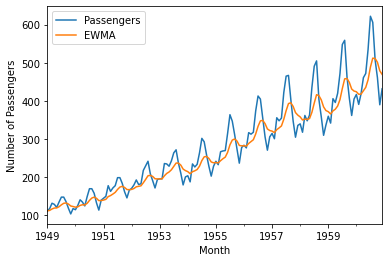

In [11]:
plt.figure(figsize=(10,5))
df.plot()
plt.ylabel('Number of Passengers')
plt.show()

- Now, compute EWMA manually and check that it's equal to pandas implementation:

In [12]:
manual_ewma = []
for i in df['Passengers'].to_numpy():
    if len(manual_ewma)>0:
        x_bar = alpha*i + (1-alpha)*manual_ewma[-1]
    else:
        x_bar = i # initialize with first value, could be any value but this makes sense
    manual_ewma.append(x_bar)

df['Manual_EWMA'] = manual_ewma

<Figure size 432x288 with 0 Axes>

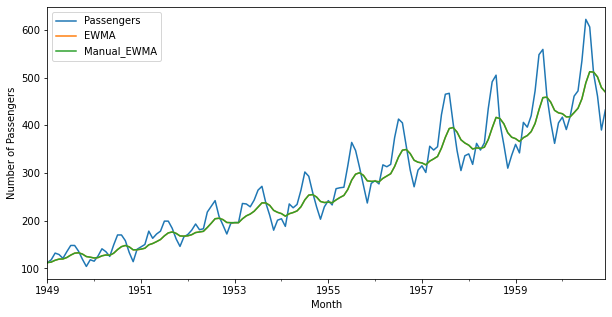

In [13]:
plt.figure()
df.plot(figsize=(10,5))
plt.ylabel('Number of Passengers')
plt.show()

- The manual and pandas-computed EWMA are the same (curves lie on top of each other)
    - Can further check per entry in df but omitting for brevity
- Clear manual calculation to clean up df:

In [14]:
df.drop('Manual_EWMA',axis=1,inplace=True)

In [15]:
df.columns

Index(['Passengers', 'EWMA'], dtype='object')

# SES Code
- Implement Simple Exponential Smoothing (SES) forecasting
- Use statsmodels library for methods

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

- SES model object from statsmodels must be constructed with data
    - Recall that this df (from previous section) is indexed by datetime type

In [17]:
ses = SimpleExpSmoothing(df['Passengers'])
df.index

/home/les67/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

- The index frequency refers to the frequency of the time bins, which in our case is monthly
- The full list of available types is found here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
- Since ours is currently set to None, let's set it manually and call the SES again (should see no warnings)
    - Use of 'legacy-heuristic' method to comply with model from lecture

In [18]:
df.index.freq = 'MS' # month start frequency
ses = SimpleExpSmoothing(df['Passengers'],initialization_method='legacy-heuristic')

- Now apply the exp smoothing with $\alpha=0.2$ as chosen in previous section
- optimized is set to False because, in this case, we _do not_ wish for the fitting procedure to find the optimal alpha

In [19]:
res = ses.fit(smoothing_level=alpha,optimized=False)
res.fittedvalues

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

- Another way to get the fitted values is to use the predict method and apply it to the data manually
    - save this under new column 'SES'
- This can be done by passing in the start and end indices of the data:

In [20]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

- This results are automatically saved under `res.fittedvalues` as a pandas series
- Let's compare those results with the fitted values
    - Note that np.allclose() is used to compare array equality up to some tolerance

In [21]:
np.allclose(df['SES'],res.fittedvalues)

True

- Now plot the dataframe which consists of the original data, the Pandas EWMA smoothing, and the statsmodels SES smoothing:

<Figure size 432x288 with 0 Axes>

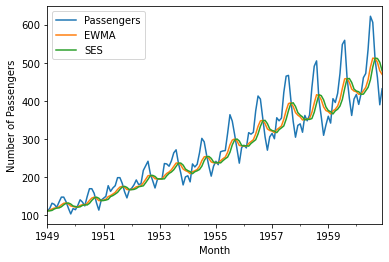

In [22]:
plt.figure()
df.plot()
plt.ylabel('Number of Passengers')
plt.show()

- Note that the SES are different from Pandas: they seem to be shifted up by one unit
- Check entries in dataframe:

In [23]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


- SES column has a shift up by one with the first entry being repeated once
    - if we were to shift SES by one, it would match with EWMA
- Recall SES is a forecasting model which is defined differently from traditional EWMA
    - SES forecast time index is moved up by one step
$$
\begin{align}
   \text{Forecast eq.: } \hat{y}_{t+h|t} &= l_t,\,\,h=1,2,3,\ldots \\
   \text{Smoothing eq.: }l_t &= \alpha y_t + (1-\alpha)l_{t-1}
\end{align}
$$   
    - EWMA is represented by the level $l_t$, but the prediction $\hat{y}$ is assigned the level from the previous time step, so it should be "lagging begind" one time step
- Moving on, let's actually do a forecast (not just a fit) by splitting the dataset into "training" and "testing" data sets:

In [24]:
N_test = 12 # split data set at last 12 entries
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

# Fit model with training set
ses = SimpleExpSmoothing(train['Passengers'],initialization_method='legacy-heuristic')
res = ses.fit()

- Now save the fitted values and the forecast values to the datframe:

<Figure size 432x288 with 0 Axes>

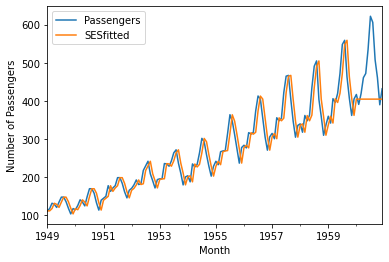

In [25]:
# Get the appropriate indices
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

# Save fitted values and forecast results
df.loc[train_idx,'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test) # pass in forecast horizon

# Plot and check results
plt.figure()
df[['Passengers','SESfitted']].plot()
plt.ylabel('Number of Passengers')
plt.show()

- Prediction lags, which is correct as investigated above
- Forecast is constant since $\hat{y}_{t+h|t}=l_t$ no matter what $h$
- Futhermore, note that the curve follows the original data very closely (it's not smooth)
    - Guess is that the fitted $\alpha$ is close to 1, let's check this:

In [26]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

- Guess is correct
- Our fitted model is simply doing nearly the naive forecast, i.e copying the last known value in the series 

# Holt's Linear Trend Model
- Apply Holt's Linear Trend Model to Passengers data from same df as previous two sections

In [27]:
from statsmodels.tsa.holtwinters import Holt

<Figure size 432x288 with 0 Axes>

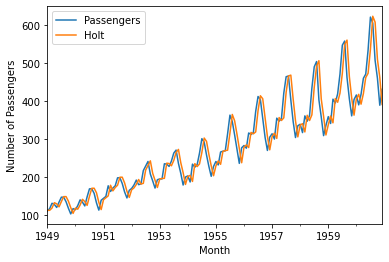

In [28]:
# Load model and fit
holt = Holt(df['Passengers'],initialization_method='legacy-heuristic') # instantiate model

res_h = holt.fit() # fit model to obtain optimal params alpha and beta
df['Holt'] = res_h.fittedvalues # saved fitted values to dataframe

# Plot
plt.figure()
df[['Passengers','Holt']].plot()
plt.ylabel('Number of Passengers')
plt.show()

- As with SES, Holt's LTM is lagging behind by one unit
- Now split data into train and test as above to perform a forecast:

<Figure size 432x288 with 0 Axes>

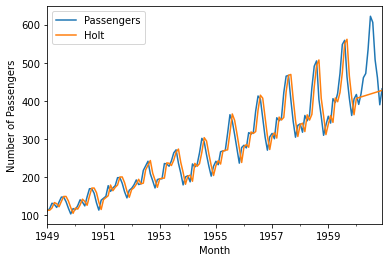

In [29]:
# Load and fit train model
holt = Holt(train['Passengers'],initialization_method='legacy-heuristic')
res_h = holt.fit()
df.loc[train_idx,'Holt'] = res_h.fittedvalues # saved fitted values

# Forecast on test set
df.loc[test_idx,'Holt'] = res_h.forecast(N_test)

# Plot
plt.figure()
df[['Passengers','Holt']].plot()
plt.ylabel('Number of Passengers')
plt.show()

- Unlike SES, we now see a linear trend upwards!

# Holt-Winters Model
- Apply Holt-Winters model to Passengers data from above
- Note that in statsmodel, Holt-Winters is represented by the ExponetialSmoothing class
- Directly train to fit and test to forecast
- First, we try an additive H-W model

In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

<Figure size 432x288 with 0 Axes>

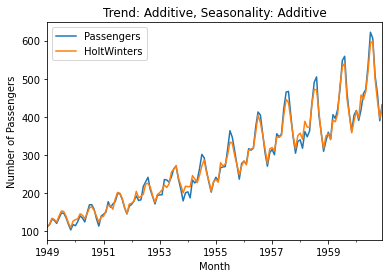

In [31]:
# Trend: additive, Seasonality: additive, Period = 12 (months)
hw = ExponentialSmoothing(train['Passengers'],initialization_method='legacy-heuristic',
                         trend='add',seasonal='add',seasonal_periods=12)

res_hw = hw.fit() # fit model

# Save fitted value and forecast
df.loc[train_idx,'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx,'HoltWinters'] = res_hw.forecast(N_test)

# Plot
plt.figure()
df[['Passengers','HoltWinters']].plot()
plt.ylabel('Number of Passengers')
plt.title('Trend: Additive, Seasonality: Additive')
plt.show()

- Note how the lagging problem from previous two sections has been cleared, thanks to the use of the full H-W model
- Let's compute RSME and MAE as error metrics
    - Instructor suggests to compute these manually
    - Note that SES, Holt's Linear, and Holt-Winters model are fit by minimizing squared error so using the RMSE as metric seems appropriate

In [32]:
def rmse(ts,pred):
    '''
    ts is the original time series data
    pred is the HW result (fitted or forecasted)
    Since RSME is symmetrical, input order doesn't actually matter
    '''
    return np.sqrt(np.mean((ts-pred)**2))

def mae(ts,pred):
    '''
    Same as above
    '''
    return np.mean(np.abs(ts-pred))

In [33]:
print('RMSE')
print('\tTrain: ',rmse(train['Passengers'],res_hw.fittedvalues))
print('\tTest: ',rmse(test['Passengers'],res_hw.forecast(N_test)))
print('MAE')
print('\tTrain: ',mae(train['Passengers'],res_hw.fittedvalues))
print('\tTest: ',mae(test['Passengers'],res_hw.forecast(N_test)))

RMSE
	Train:  11.624714430673354
	Test:  16.978029847029934
MAE
	Train:  9.006650631052384
	Test:  13.37759090303536


- Now try a H-W model with additive trend and multiplicative seasonality
    - From the raw data, it does seem that the amplitude of the trend increases as time goes by so this should be a better fit/forecast

<Figure size 432x288 with 0 Axes>

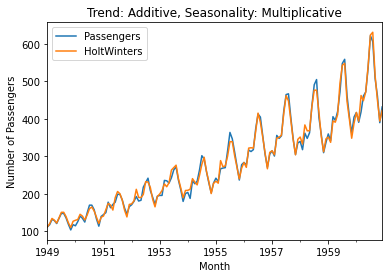

In [34]:
# Trend: additive, Seasonality: multiplicative, Period = 12 (months)
hw = ExponentialSmoothing(train['Passengers'],initialization_method='legacy-heuristic',
                         trend='add',seasonal='mul',seasonal_periods=12)

res_hw = hw.fit() # fit model

# Save fitted value and forecast
df.loc[train_idx,'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx,'HoltWinters'] = res_hw.forecast(N_test)

# Plot
plt.figure()
df[['Passengers','HoltWinters']].plot()
plt.ylabel('Number of Passengers')
plt.title('Trend: Additive, Seasonality: Multiplicative')
plt.show()

- This does seem like a better fit and forecast (peaks match improved, for example)
- Check the errors:

In [35]:
print('RMSE')
print('\tTrain: ',rmse(train['Passengers'],res_hw.fittedvalues))
print('\tTest: ',rmse(test['Passengers'],res_hw.forecast(N_test)))
print('MAE')
print('\tTrain: ',mae(train['Passengers'],res_hw.fittedvalues))
print('\tTest: ',mae(test['Passengers'],res_hw.forecast(N_test)))

RMSE
	Train:  9.76799520516801
	Test:  15.810870232569963
MAE
	Train:  7.604272329965025
	Test:  10.30368288348438


- Train and test errors are better than add-add model
- Finally, try H-W model with multiplicative trend and multiplicative seasonality
    - Perhaps the increasing trend of the data is not linear but, perhaps, exponential

/home/les67/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


<Figure size 432x288 with 0 Axes>

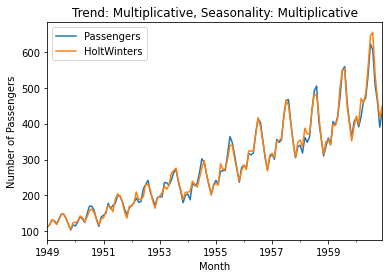

In [36]:
# Trend: multiplicative, Seasonality: multiplicative, Period = 12 (months)
hw = ExponentialSmoothing(train['Passengers'],initialization_method='legacy-heuristic',
                         trend='mul',seasonal='mul',seasonal_periods=12)

res_hw = hw.fit() # fit model

# Save fitted value and forecast
df.loc[train_idx,'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx,'HoltWinters'] = res_hw.forecast(N_test)

# Plot
plt.figure()
df[['Passengers','HoltWinters']].plot()
plt.ylabel('Number of Passengers')
plt.title('Trend: Multiplicative, Seasonality: Multiplicative')
plt.show()

- Hard to tell visually if this is an improvement
- Check the errors:

In [37]:
print('RMSE')
print('\tTrain: ',rmse(train['Passengers'],res_hw.fittedvalues))
print('\tTest: ',rmse(test['Passengers'],res_hw.forecast(N_test)))
print('MAE')
print('\tTrain: ',mae(train['Passengers'],res_hw.fittedvalues))
print('\tTest: ',mae(test['Passengers'],res_hw.forecast(N_test)))

RMSE
	Train:  9.61792487803932
	Test:  25.80687515735493
MAE
	Train:  7.112379992634935
	Test:  20.844988412204554


- Train errors are similar to add-mult model but test erros are much worse
- In this case, we conclude the mult-mult model is overfitting our data

# Walk-Forward Validation
- Perform walk-forward validation to find optimal parameters for H-W model, applied to Passengers dataset

In [38]:
import itertools
from sklearn.metrics import mean_squared_error

In [39]:
df = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'
df.shape

(144, 1)

- Set the forecast horizon at $h=12$ and validate over 10 steps
- The variable `Ntest` will define the starting index for the test set
    - Since we want a validation set of 12 data points and we need to take 10 steps over the process, `Ntest` should be = len(time series) - $h$ - # of steps + 1 (to make it inclusive of the end)

In [40]:
h = 12 # forecast horizon
steps = 10
Ntest = len(df) - h - steps + 1

- We'll perform a gridsearch over a combinations of parameters
- Define possible values for each param:
    - Note that the 0 value for use_boxcox corresponds to `log` transformation
    - Contraty to the docs https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html, simply using 'log' throws an error (see source https://www.statsmodels.org/dev/_modules/statsmodels/tsa/holtwinters/model.html#ExponentialSmoothing)

In [41]:
# params to explore
trend_type_list = ['add','mul']
seasonal_type_list = ['add','mul']
damped_trend_list = [True, False] # does the trend seem to damp over time?
init_method_list = ['estimated','heuristic','legacy-heuristic']
use_boxcox_list = [True, False, 0] # do we need to transform the data?

- For each set of params we define the walk-forward method:
    - debugging built in as suggested by instructor to check the number of steps
    - Will perform desired number of steps in interation and return the average MSE 

In [42]:
def walkforward(
    trend_type,
    seasonal_type,
    damped_trend,
    init_method,
    use_boxcox,
    debug=False):
    
    errors = [] # used to store errors over steps forward
    
    # debug
    seen_last = False # at the end of interation, have we seen the last data point in the series?
    steps_completed = 0 # should equal the desired number of steps by end of iterations
    
    # Ntest is the index of the last point in the train set
    for end_train_idx in range(Ntest,len(df)-h+1):
        
        # define train and test sets
        train = df.iloc[:end_train_idx] # will increase in size by one every iteration
        test = df.iloc[end_train_idx:end_train_idx+h] # only goes up to relative forecast horizon
        
        # debug checks
        steps_completed+=1
        if test.index[-1] == df.index[-1]: # if we're at the end of time seris
            seen_last = True
            
       # Instantiate model
        hw = ExponentialSmoothing(
            train['Passengers'],
            initialization_method=init_method,
            trend=trend_type,
            damped_trend=damped_trend,
            seasonal=seasonal_type,
            seasonal_periods=12, # fixed for our dataset
            use_boxcox=use_boxcox)
        # Fit model
        res_hw = hw.fit()
        
       # Compute errors on test set
        fcast = res_hw.forecast(h)
        error = mean_squared_error(test['Passengers'],fcast)
        errors.append(error)
        
    if debug:
        print('seen last: ',seen_last)
        print('steps completed: ',steps_completed)
        
    return np.mean(errors) # return average error over iterations

- Test above function with single set of params:

In [43]:
walkforward('add','add',False,'legacy-heuristic',0,debug=True)

seen last:  True
steps completed:  10


2521.0271721807176

- Now we use walkforward on all possible param combinations
- For this we use itertools.product which returns a cartersian product of input lists

In [44]:
tuple_options_list = (
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list,
    use_boxcox_list)

# Check it works
for i in itertools.product(*tuple_options_list):
    print(i)

('add', 'add', True, 'estimated', True)
('add', 'add', True, 'estimated', False)
('add', 'add', True, 'estimated', 0)
('add', 'add', True, 'heuristic', True)
('add', 'add', True, 'heuristic', False)
('add', 'add', True, 'heuristic', 0)
('add', 'add', True, 'legacy-heuristic', True)
('add', 'add', True, 'legacy-heuristic', False)
('add', 'add', True, 'legacy-heuristic', 0)
('add', 'add', False, 'estimated', True)
('add', 'add', False, 'estimated', False)
('add', 'add', False, 'estimated', 0)
('add', 'add', False, 'heuristic', True)
('add', 'add', False, 'heuristic', False)
('add', 'add', False, 'heuristic', 0)
('add', 'add', False, 'legacy-heuristic', True)
('add', 'add', False, 'legacy-heuristic', False)
('add', 'add', False, 'legacy-heuristic', 0)
('add', 'mul', True, 'estimated', True)
('add', 'mul', True, 'estimated', False)
('add', 'mul', True, 'estimated', 0)
('add', 'mul', True, 'heuristic', True)
('add', 'mul', True, 'heuristic', False)
('add', 'mul', True, 'heuristic', 0)
('add

- Works
- Now, run the actual optimization:

In [45]:
# metrics to compare performance to
lowest_error = float('inf')
best_params = None

for i in itertools.product(*tuple_options_list):
    error = walkforward(*i) # unpack the params as expected by function
    
    if error < lowest_error:
        lowest_error = error
        best_params = i

/home/les67/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/les67/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/les67/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/les67/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/les67/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/les67/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/les67/anaconda3/lib/python3.7/site-packa

In [46]:
print('Results:')
print('\tlowest error: ',lowest_error)
print('\ttrend_type: ',best_params[0])
print('\tseasonal_type: ',best_params[1])
print('\tdamped_trend: ',best_params[2])
print('\tinit_method: ',best_params[3])
print('\tuse_boxcox: ',best_params[4])

Results:
	lowest error:  292.21421260567297
	trend_type:  mul
	seasonal_type:  mul
	damped_trend:  True
	init_method:  legacy-heuristic
	use_boxcox:  False


# Application: Sales Data
- Apply Holt-Winters model to sales of champagne data
- Use $r^2$ as error metric
    - We note this https://towardsdatascience.com/explaining-negative-r-squared-17894ca26321 as important since interpretation of $r^2$ may be an issue (--wondering if it can be negative and why?)

In [47]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv

File ‘perrin-freres-monthly-champagne.csv’ already there; not retrieving.



In [48]:
from sklearn.metrics import r2_score

In [49]:
# Read in data
df = pd.read_csv('perrin-freres-monthly-champagne.csv',
                index_col='Month',
                skipfooter=2, # instructor notes there's some junk at end of file
                parse_dates=True,
                engine='python' # clears an inconsequential warning
                )
df.columns = ['Sales'] # change ugly original col name to sales
df.index.freq = 'MS'
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


- What does the data look like?

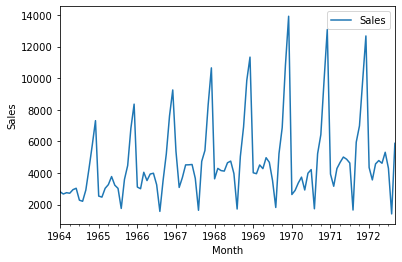

In [50]:
df.plot(); # semi-colon suppresses print output
plt.ylabel('Sales');

- This data clearly has seasonality and perhaps a minor trend upwards
- Skip walka-forward method and choose a fixed train and test set
    - Grab last year (12 months) as test set

In [51]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

# Get the appropriate indices for later
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

- Instantiate and fit the H-W model
    - Use multiplicative seasonality since amplitude of seasonal spikes seems to icrease over time (up to a point)
- Also save fitted values and forecast results to df

In [52]:
hw = ExponentialSmoothing(
    train['Sales'],
    initialization_method='legacy-heuristic',
    trend='add',
    seasonal='mul',
    seasonal_periods=12 # a year seems reasonable
)

res_hw = hw.fit() # fit

# save fitted values
df.loc[train_idx,'HoltWinters_Train'] = res_hw.fittedvalues
df.loc[test_idx,'HoltWinters_Test'] = res_hw.forecast(Ntest) # save under different columns to display in different colors in plot

- Plot original data, fitted values, and forecast values:

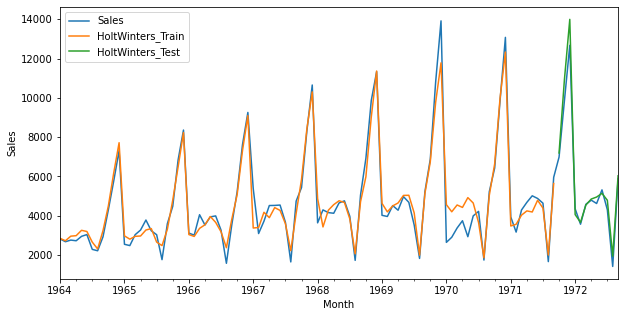

In [53]:
df[['Sales','HoltWinters_Train','HoltWinters_Test']].plot(figsize=(10,5));
plt.ylabel('Sales')
plt.show()

- What are the respective $r^2$ values?

In [54]:
print('r^2:')
print('\tTrain: ',r2_score(train['Sales'],res_hw.fittedvalues))
print('\tTest: ',r2_score(test['Sales'],res_hw.forecast(Ntest)))

r^2:
	Train:  0.9384142140780656
	Test:  0.9618946829006546


# Application: Stock Predictions
- Apply H-W model to Google stock prices from S&P 500

In [55]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

--2022-10-16 21:36:15--  https://lazyprogrammer.me/course_files/sp500sub.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 2606:4700:3030::ac43:d5a6, 2606:4700:3031::6815:17d2, 172.67.213.166, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|2606:4700:3030::ac43:d5a6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25473876 (24M) [text/csv]
Saving to: ‘sp500sub.csv’

sp500sub.csv        100%[===================>]  24.29M   508KB/s    in 36s     

2022-10-16 21:36:52 (692 KB/s) - ‘sp500sub.csv’ saved [25473876/25473876]



In [56]:
df = pd.read_csv('sp500sub.csv',index_col='Date',parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


- Get google's closing stock prices and plot
    - Also apply log transform to make the trend more linear $\leftarrow$ this was suggested by instructor although it's not immediately apparent in the graph

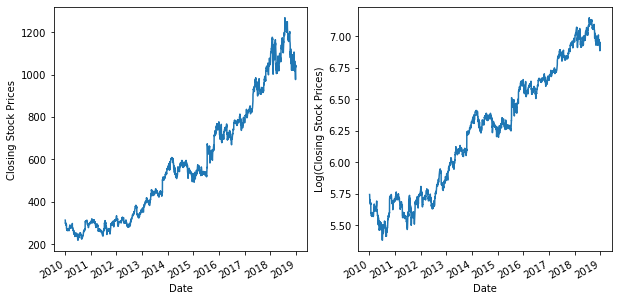

In [58]:
# Closing prices
goog = df[df['Name']=='GOOG'][['Close']].copy()

# Log closing prices
goog['LogClose'] = np.log(goog['Close'])

# Plot
plt.figure(figsize=(10,5))
plt.subplot(121)
goog['Close'].plot()
plt.ylabel('Closing Stock Prices')
plt.subplot(122)
goog['LogClose'].plot()
plt.ylabel('Log(Closing Stock Prices)')
plt.show()

- Split data into train and test (last 30 points):

In [60]:
# Split data into train/test
Ntest = 30
train = goog.iloc[:-Ntest]
test = goog.iloc[-Ntest:]

# Get the train/test indices
train_idx = goog.index <= train.index[-1]
test_idx = goog.index > train.index[-1]

- Instantiate the H-W model, fit, forecast, and plot:
    - With the log data
    - Doesn't seem to be (a consistent) seasonality of the data

/home/les67/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/les67/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


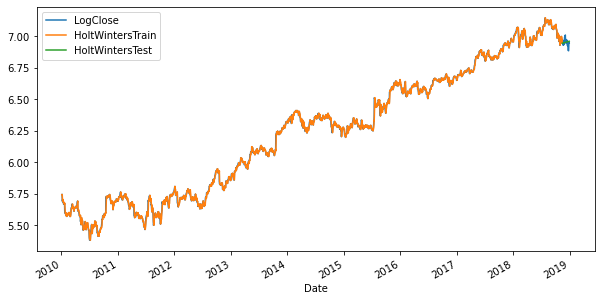

In [62]:
hw = ExponentialSmoothing(train['LogClose'],
                         initialization_method='legacy-heuristic',
                         trend='add',
                         seasonal=None)

res_hw = hw.fit() # fit data

# fit and forecast
goog.loc[train_idx,'HoltWintersTrain'] = res_hw.fittedvalues
goog.loc[test_idx,'HoltWintersTest'] = res_hw.forecast(Ntest).to_numpy()

# plot
goog[['LogClose','HoltWintersTrain','HoltWintersTest']].plot(figsize=(10,5));

- To get a better picture of the performance, let's zoom into the last 100 data points:

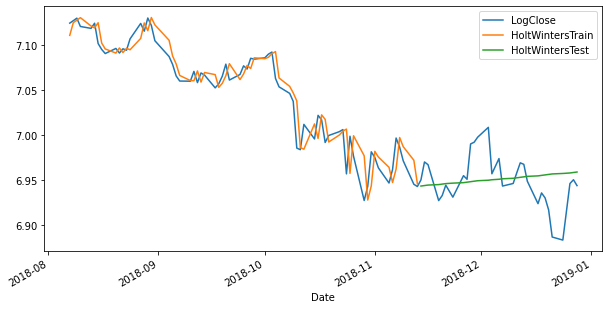

In [63]:
goog.iloc[-100:][['LogClose','HoltWintersTrain','HoltWintersTest']].plot(figsize=(10,5));

- Model does well on train set but poorly on test set
    - This is because we did not add seasonality, i.e we used Holt's linear trend model instead of the H-W model
- As an additional exercise, instructor asked to compare Holt's linear trend forecast with the naive forecast and compare error metrics
    - Recall that the naive forecast assigns the last known value (in fitted/"train" set) to every future point in the horizon

In [73]:
# Naive forecast
goog.loc[test_idx,'NaiveForecast'] = goog['HoltWintersTrain'][train.index[-1]]

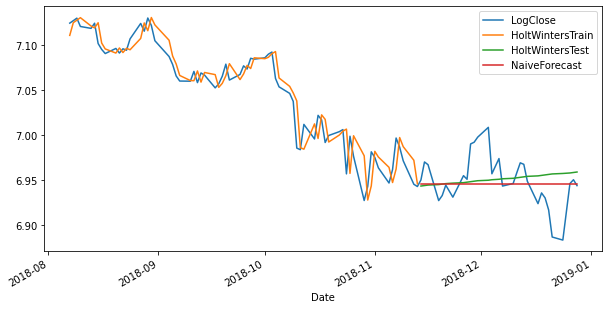

In [74]:
goog.iloc[-100:][['LogClose','HoltWintersTrain','HoltWintersTest','NaiveForecast']].plot(figsize=(10,5));

- Compare metrics:

In [77]:
print('r^2 scores:')
print("\tHolt's Linear Model: ",r2_score(goog.loc[test_idx,'HoltWintersTest'],goog.loc[test_idx,'LogClose']))
print("\tNaive Forecast: ",r2_score(goog.loc[test_idx,'NaiveForecast'],goog.loc[test_idx,'LogClose']))

r^2 scores:
	Holt's Linear Model:  -40.596759010000184
	Naive Forecast:  -1.117144573901726e+26


- So Holt's linear model gives the better forecast after all 